# RadioML 2016.10a 数据集探索性数据分析 (EDA)

本笔记本对RadioML 2016.10a数据集进行全面的探索性数据分析，包括：
- 数据集基本信息和统计特征
- 调制类型和信噪比分布
- 信号时域和频域特征可视化
- 星座图分析
- 不同SNR下的信号质量分析

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import signal
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体和图表样式
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
# sns.set_style("whitegrid")
# plt.rcParams['figure.figsize'] = (12, 8)
# plt.rcParams['figure.dpi'] = 100

print("已导入所需库")

已导入所需库


In [2]:
def load_radioml_data(file_path):
    """加载RadioML数据集"""
    print(f"正在从 {file_path} 加载数据集...")
    try:
        with open(file_path, 'rb') as f:
            data = pickle.load(f, encoding='latin1')
        print("数据集加载成功！")
        return data
    except Exception as e:
        print(f"加载数据集时出错: {e}")
        return None

# 加载数据集
dataset_path = "../RML2016.10a_dict.pkl"
dataset = load_radioml_data(dataset_path)

正在从 ../RML2016.10a_dict.pkl 加载数据集...
数据集加载成功！


In [3]:
# 基本数据集信息探索
if dataset is not None:
    print("\n=== RadioML 2016.10a 数据集基本信息 ===")
    
    # 获取调制类型和SNR值
    snrs = sorted(list(set([k[1] for k in dataset.keys()])))
    mods = sorted(list(set([k[0] for k in dataset.keys()])))
    
    print(f"\n调制类型数量: {len(mods)}")
    print(f"调制类型: {mods}")
    
    print(f"\nSNR范围: {min(snrs)} 到 {max(snrs)} dB")
    print(f"SNR步长: {snrs[1] - snrs[0]} dB")
    print(f"SNR数量: {len(snrs)}")
    print(f"SNR值: {snrs}")
    
    # 获取数据样本信息
    example_key = list(dataset.keys())[0]
    example_data = dataset[example_key]
    print(f"\n单个样本形状: {example_data.shape}")
    print(f"每个调制-SNR组合的样本数: {len(example_data)}")
    
    # 计算总样本数
    total_samples = sum(len(dataset[k]) for k in dataset.keys())
    print(f"\n总样本数: {total_samples:,}")
    print(f"总键值对数: {len(dataset.keys())}")
    print(f"预期样本数: {len(mods)} × {len(snrs)} × 1000 = {len(mods) * len(snrs) * 1000:,}")
else:
    print("数据集加载失败，无法进行分析")


=== RadioML 2016.10a 数据集基本信息 ===

调制类型数量: 11
调制类型: ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']

SNR范围: -20 到 18 dB
SNR步长: 2 dB
SNR数量: 20
SNR值: [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]

单个样本形状: (1000, 2, 128)
每个调制-SNR组合的样本数: 1000

总样本数: 220,000
总键值对数: 220
预期样本数: 11 × 20 × 1000 = 220,000


In [4]:
# 数据分布分析
if dataset is not None:
    print("\n=== 数据分布分析 ===")
    
    # 创建数据分布DataFrame
    distribution_data = []
    
    for mod in mods:
        for snr in snrs:
            key = (mod, snr)
            if key in dataset:
                num_samples = len(dataset[key])
                distribution_data.append({
                    'Modulation': mod,
                    'SNR_dB': snr,
                    'Samples': num_samples
                })
    
    df_dist = pd.DataFrame(distribution_data)
    
    # 按调制类型统计
    mod_counts = df_dist.groupby('Modulation')['Samples'].sum().sort_values(ascending=False)
    print("\n各调制类型样本数量:")
    for mod, count in mod_counts.items():
        print(f"{mod:8}: {count:,} 个样本")
    
    # 按SNR统计
    snr_counts = df_dist.groupby('SNR_dB')['Samples'].sum().sort_values(ascending=False)
    print("\n各SNR级别样本数量 (前10个):")
    for snr, count in snr_counts.head(10).items():
        print(f"{snr:3} dB: {count:,} 个样本")
    
    print(f"\n数据集完整性检查: {'✓ 完整' if len(distribution_data) == len(mods) * len(snrs) else '✗ 不完整'}")


=== 数据分布分析 ===

各调制类型样本数量:
8PSK    : 20,000 个样本
AM-DSB  : 20,000 个样本
AM-SSB  : 20,000 个样本
BPSK    : 20,000 个样本
CPFSK   : 20,000 个样本
GFSK    : 20,000 个样本
PAM4    : 20,000 个样本
QAM16   : 20,000 个样本
QAM64   : 20,000 个样本
QPSK    : 20,000 个样本
WBFM    : 20,000 个样本

各SNR级别样本数量 (前10个):
-20 dB: 11,000 个样本
-18 dB: 11,000 个样本
-16 dB: 11,000 个样本
-14 dB: 11,000 个样本
-12 dB: 11,000 个样本
-10 dB: 11,000 个样本
 -8 dB: 11,000 个样本
 -6 dB: 11,000 个样本
 -4 dB: 11,000 个样本
 -2 dB: 11,000 个样本

数据集完整性检查: ✓ 完整


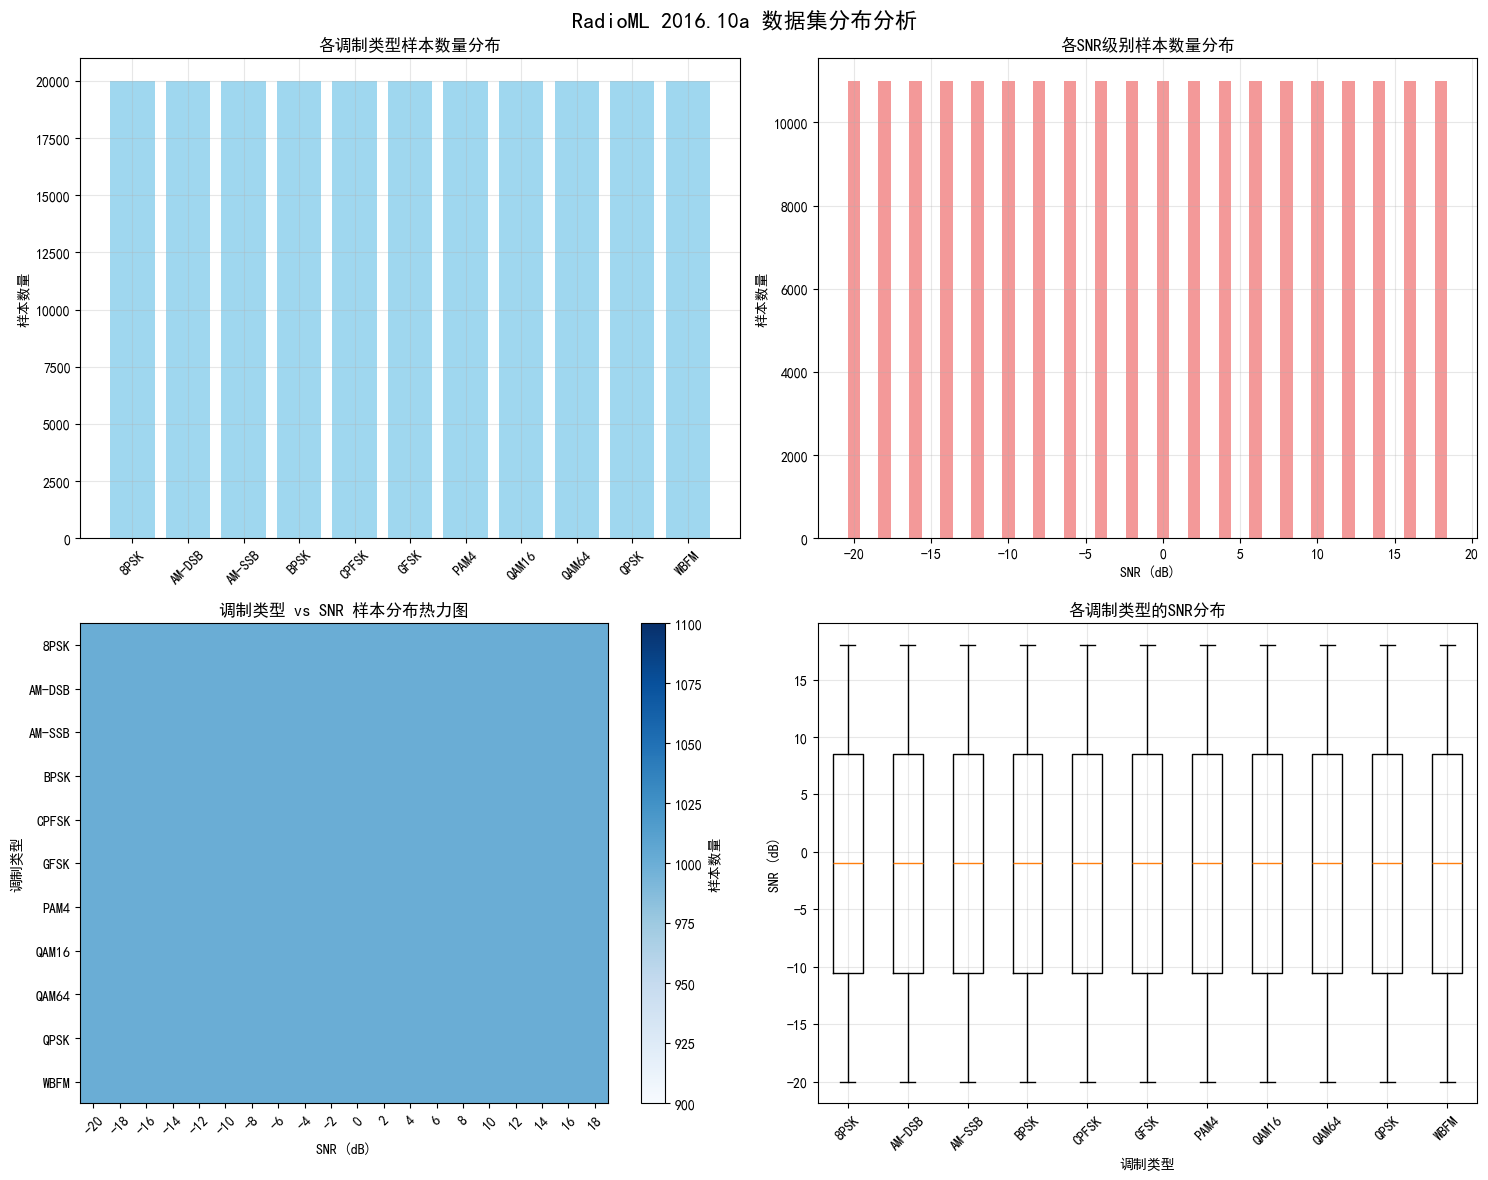

In [5]:
# 分布可视化
if dataset is not None:
    # 1. 调制类型分布柱状图
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('RadioML 2016.10a 数据集分布分析', fontsize=16, fontweight='bold')
    
    # 调制类型分布
    axes[0, 0].bar(range(len(mod_counts)), mod_counts.values, color='skyblue', alpha=0.8)
    axes[0, 0].set_xticks(range(len(mod_counts)))
    axes[0, 0].set_xticklabels(mod_counts.index, rotation=45)
    axes[0, 0].set_title('各调制类型样本数量分布')
    axes[0, 0].set_ylabel('样本数量')
    axes[0, 0].grid(True, alpha=0.3)
    
    # SNR分布
    axes[0, 1].bar(snr_counts.index, snr_counts.values, color='lightcoral', alpha=0.8)
    axes[0, 1].set_title('各SNR级别样本数量分布')
    axes[0, 1].set_xlabel('SNR (dB)')
    axes[0, 1].set_ylabel('样本数量')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 调制类型vs SNR热力图
    pivot_data = df_dist.pivot(index='Modulation', columns='SNR_dB', values='Samples')
    im = axes[1, 0].imshow(pivot_data.values, cmap='Blues', aspect='auto')
    axes[1, 0].set_xticks(range(len(snrs)))
    axes[1, 0].set_xticklabels([f'{snr}' for snr in snrs], rotation=45)
    axes[1, 0].set_yticks(range(len(mods)))
    axes[1, 0].set_yticklabels(mods)
    axes[1, 0].set_title('调制类型 vs SNR 样本分布热力图')
    axes[1, 0].set_xlabel('SNR (dB)')
    axes[1, 0].set_ylabel('调制类型')
    
    # 添加颜色条
    plt.colorbar(im, ax=axes[1, 0], label='样本数量')
    
    # SNR分布箱线图
    snr_data = []
    labels = []
    for mod in mods:
        mod_snrs = df_dist[df_dist['Modulation'] == mod]['SNR_dB'].tolist()
        snr_data.append(mod_snrs)
        labels.append(mod)
    
    axes[1, 1].boxplot(snr_data, labels=labels)
    axes[1, 1].set_title('各调制类型的SNR分布')
    axes[1, 1].set_xlabel('调制类型')
    axes[1, 1].set_ylabel('SNR (dB)')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [6]:
def analyze_signal_statistics(dataset, mod, snr, num_samples=100):
    """分析特定调制类型和SNR下的信号统计特征"""
    key = (mod, snr)
    if key not in dataset:
        return None
    
    # 获取样本
    samples = dataset[key][:num_samples]
    
    # 分离I/Q分量
    i_data = samples[:, 0, :].flatten()
    q_data = samples[:, 1, :].flatten()
    
    # 计算统计特征
    stats = {
        'I_mean': np.mean(i_data),
        'I_std': np.std(i_data), 
        'I_min': np.min(i_data),
        'I_max': np.max(i_data),
        'Q_mean': np.mean(q_data),
        'Q_std': np.std(q_data),
        'Q_min': np.min(q_data), 
        'Q_max': np.max(q_data),
        'Signal_power': np.mean(i_data**2 + q_data**2),
        'SNR_estimated': snr
    }
    
    return stats

def plot_signal_examples(dataset, modulations, snr_value=18, num_samples=3):
    """绘制信号示例"""
    fig, axes = plt.subplots(len(modulations), 2, figsize=(15, 4*len(modulations)))
    fig.suptitle(f'信号示例 (SNR = {snr_value} dB)', fontsize=16, fontweight='bold')
    
    for i, mod in enumerate(modulations):
        key = (mod, snr_value)
        if key in dataset:
            # 获取前几个样本
            samples = dataset[key][:num_samples]
            
            # 时域信号
            axes[i, 0].set_title(f'{mod} - 时域信号')
            for j in range(num_samples):
                sample = samples[j]
                i_component = sample[0, :]
                q_component = sample[1, :]
                time_axis = np.arange(len(i_component))
                
                axes[i, 0].plot(time_axis, i_component, alpha=0.7, label=f'I (样本{j+1})' if j == 0 else '')
                axes[i, 0].plot(time_axis, q_component, alpha=0.7, label=f'Q (样本{j+1})' if j == 0 else '')
            
            axes[i, 0].set_xlabel('时间采样点')
            axes[i, 0].set_ylabel('幅度')
            axes[i, 0].grid(True, alpha=0.3)
            axes[i, 0].legend()
            
            # 星座图
            axes[i, 1].set_title(f'{mod} - 星座图')
            for j in range(num_samples):
                sample = samples[j]
                i_component = sample[0, :]
                q_component = sample[1, :]
                axes[i, 1].scatter(i_component, q_component, alpha=0.6, s=2)
            
            axes[i, 1].set_xlabel('I 分量')
            axes[i, 1].set_ylabel('Q 分量')
            axes[i, 1].grid(True, alpha=0.3)
            axes[i, 1].set_aspect('equal')
    
    plt.tight_layout()
    plt.show()

print("信号分析函数定义完成")

信号分析函数定义完成



=== 信号波形和星座图分析 ===
显示SNR = 18 dB下的信号示例

显示调制类型: 8PSK, AM-DSB, AM-SSB, BPSK


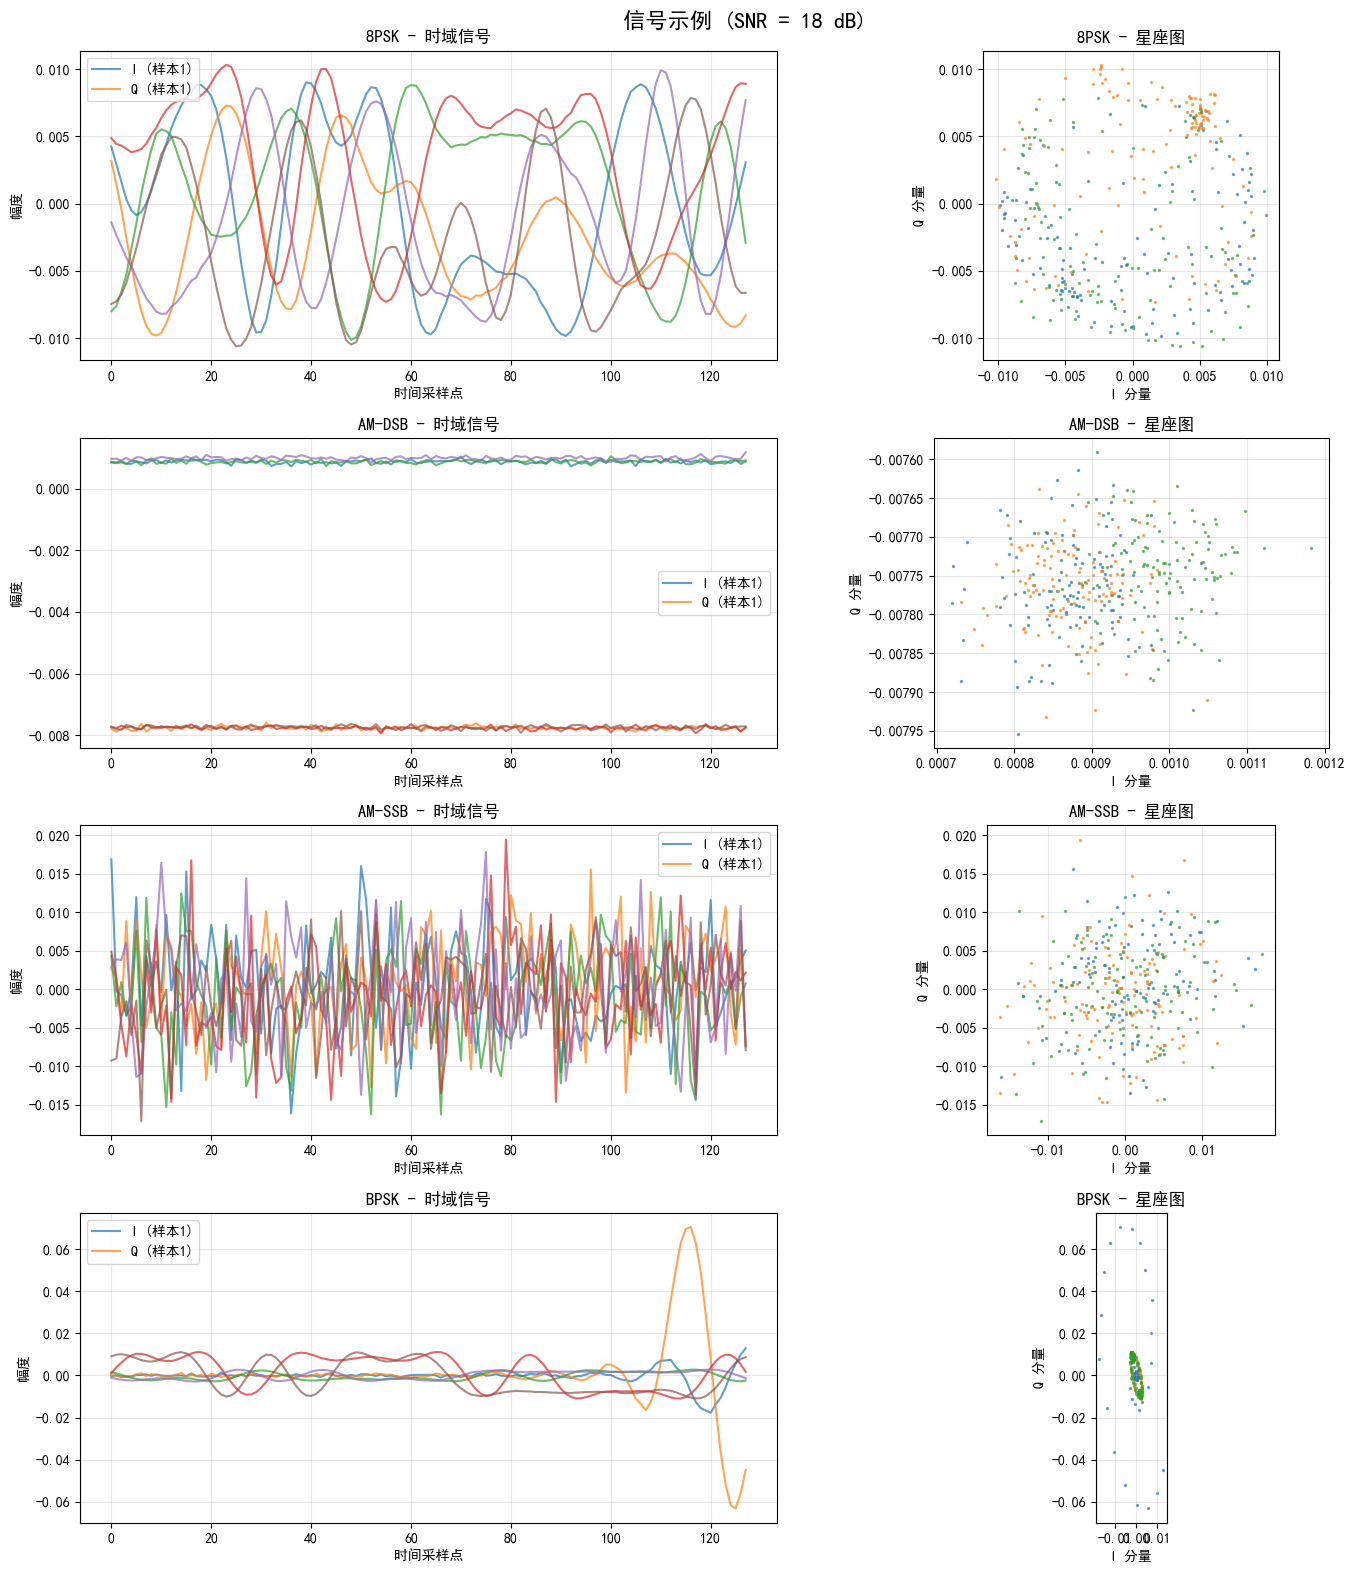


显示调制类型: CPFSK, GFSK, PAM4, QAM16


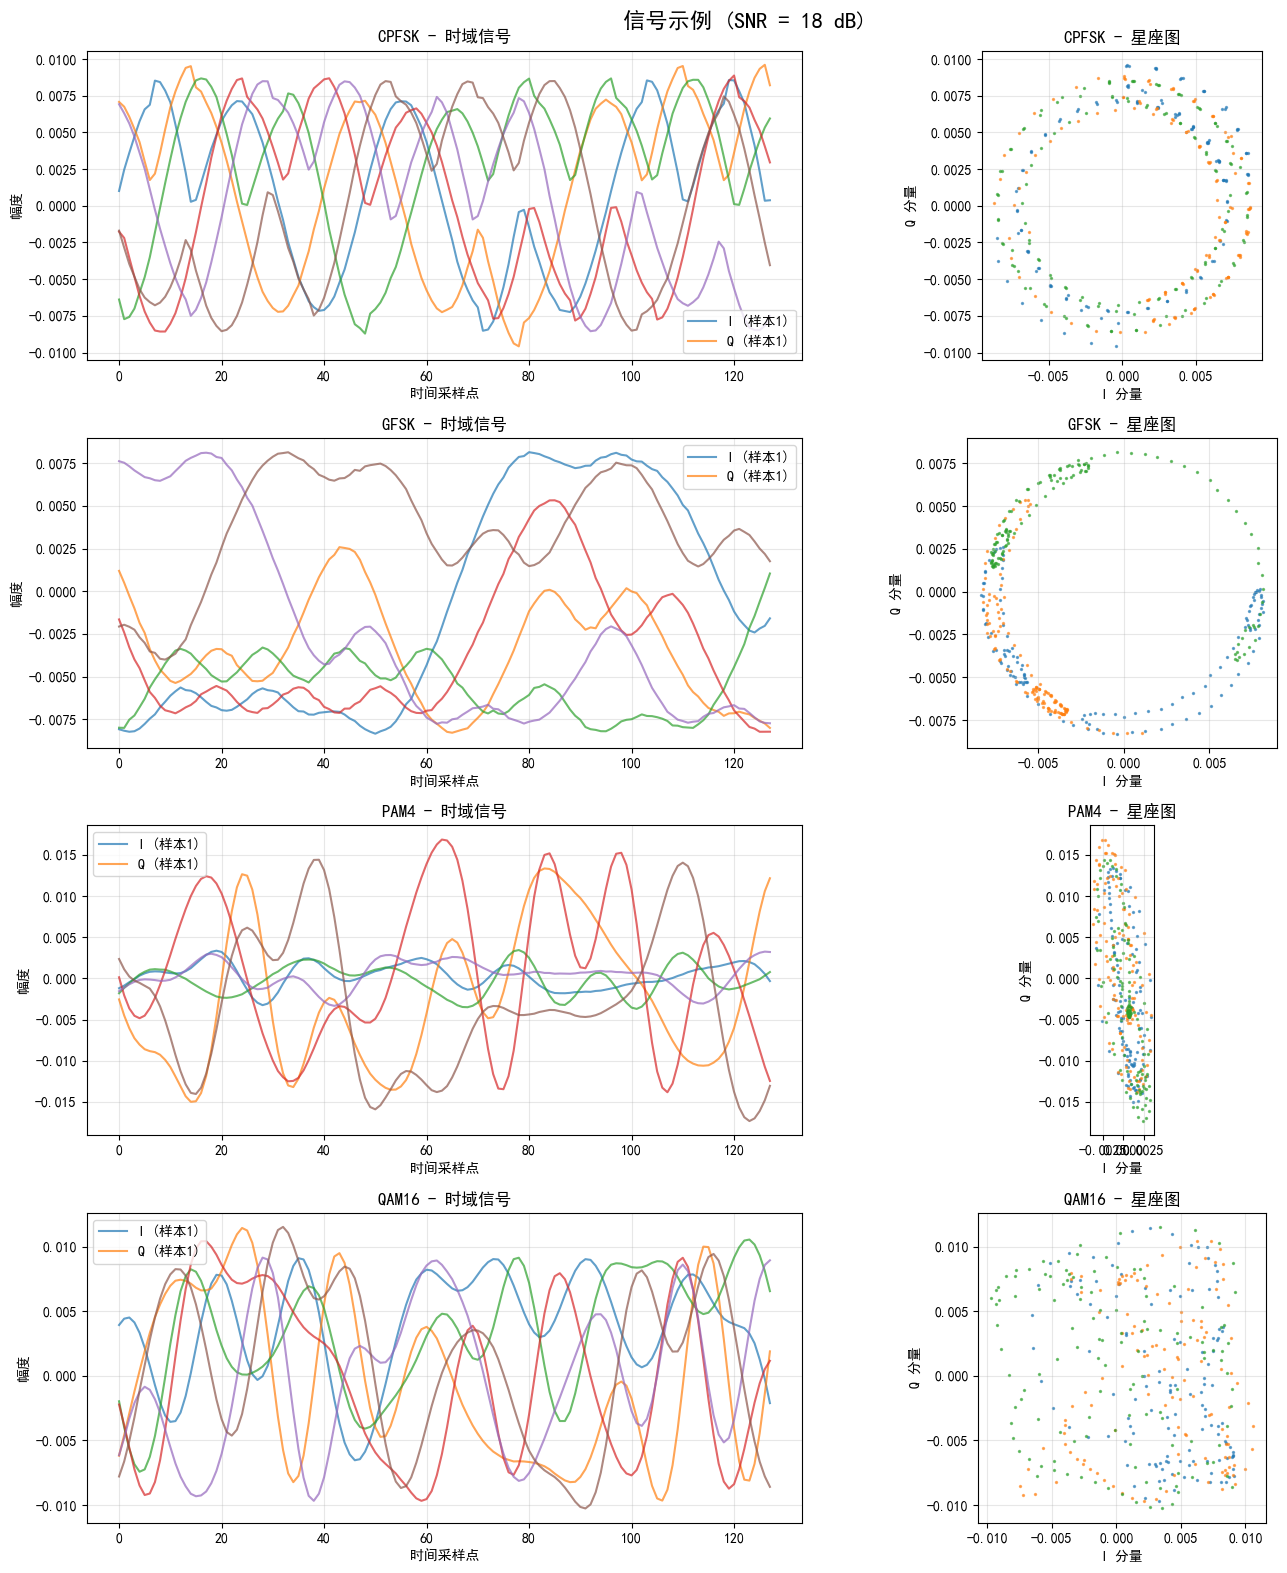


显示调制类型: QAM64, QPSK, WBFM


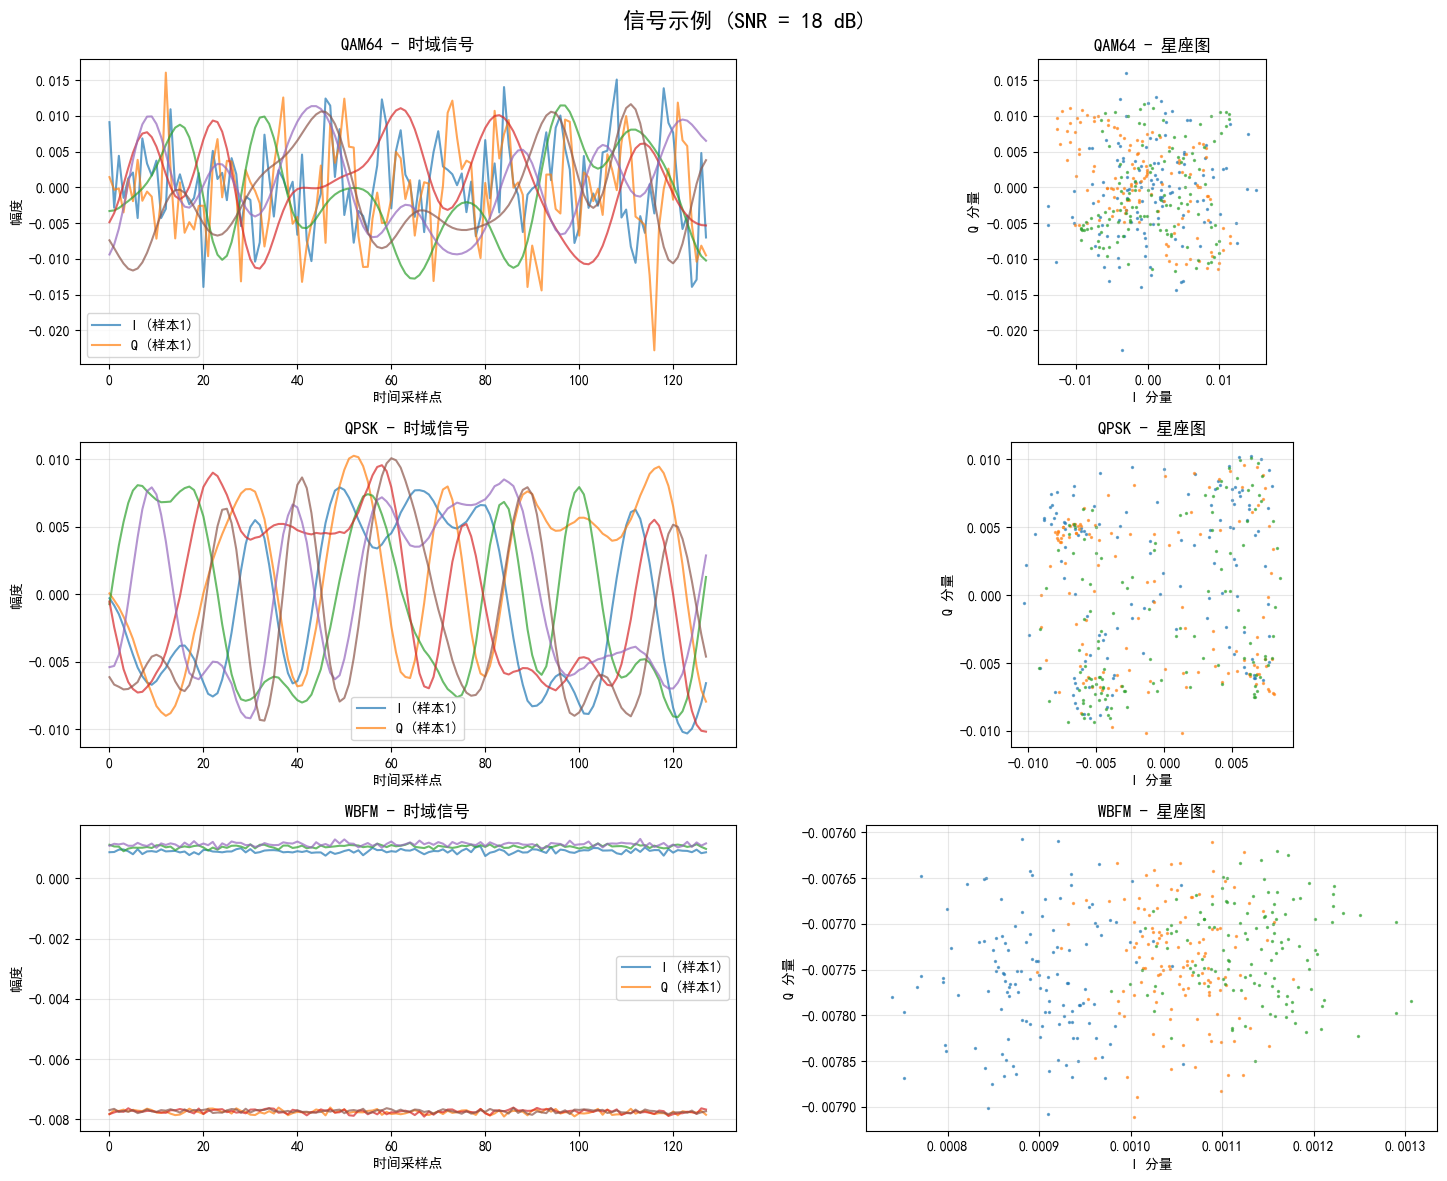

In [7]:
# 显示所有调制类型的信号示例
if dataset is not None:
    print("\n=== 信号波形和星座图分析 ===")
    
    # 选择高SNR进行清晰显示
    display_snr = 18
    print(f"显示SNR = {display_snr} dB下的信号示例\n")
    
    # 分批显示调制类型（避免图太大）
    batch_size = 4
    for i in range(0, len(mods), batch_size):
        batch_mods = mods[i:i+batch_size]
        print(f"显示调制类型: {', '.join(batch_mods)}")
        plot_signal_examples(dataset, batch_mods, display_snr)
        print()

In [8]:
# 信号统计特征分析
if dataset is not None:
    print("\n=== 信号统计特征分析 ===")
    
    # 选择几个代表性的SNR值进行分析
    analysis_snrs = [-10, 0, 10, 18]
    
    # 创建统计特征DataFrame
    stats_data = []
    
    for mod in mods:
        for snr in analysis_snrs:
            stats = analyze_signal_statistics(dataset, mod, snr)
            if stats:
                stats['Modulation'] = mod
                stats['SNR'] = snr
                stats_data.append(stats)
    
    df_stats = pd.DataFrame(stats_data)
    
    # 显示统计摘要
    print("\n信号功率统计 (按调制类型):")
    power_by_mod = df_stats.groupby('Modulation')['Signal_power'].agg(['mean', 'std', 'min', 'max'])
    print(power_by_mod.round(4))
    
    print("\n信号功率统计 (按SNR):")
    power_by_snr = df_stats.groupby('SNR')['Signal_power'].agg(['mean', 'std', 'min', 'max'])
    print(power_by_snr.round(4))


=== 信号统计特征分析 ===

信号功率统计 (按调制类型):
              mean  std     min     max
Modulation                             
8PSK        0.0001  0.0  0.0001  0.0001
AM-DSB      0.0001  0.0  0.0001  0.0001
AM-SSB      0.0001  0.0  0.0001  0.0001
BPSK        0.0001  0.0  0.0001  0.0001
CPFSK       0.0001  0.0  0.0001  0.0001
GFSK        0.0001  0.0  0.0001  0.0001
PAM4        0.0001  0.0  0.0001  0.0001
QAM16       0.0001  0.0  0.0001  0.0001
QAM64       0.0001  0.0  0.0001  0.0001
QPSK        0.0001  0.0  0.0001  0.0001
WBFM        0.0001  0.0  0.0001  0.0001

信号功率统计 (按SNR):
       mean  std     min     max
SNR                             
-10  0.0001  0.0  0.0001  0.0001
 0   0.0001  0.0  0.0001  0.0001
 10  0.0001  0.0  0.0001  0.0001
 18  0.0001  0.0  0.0001  0.0001


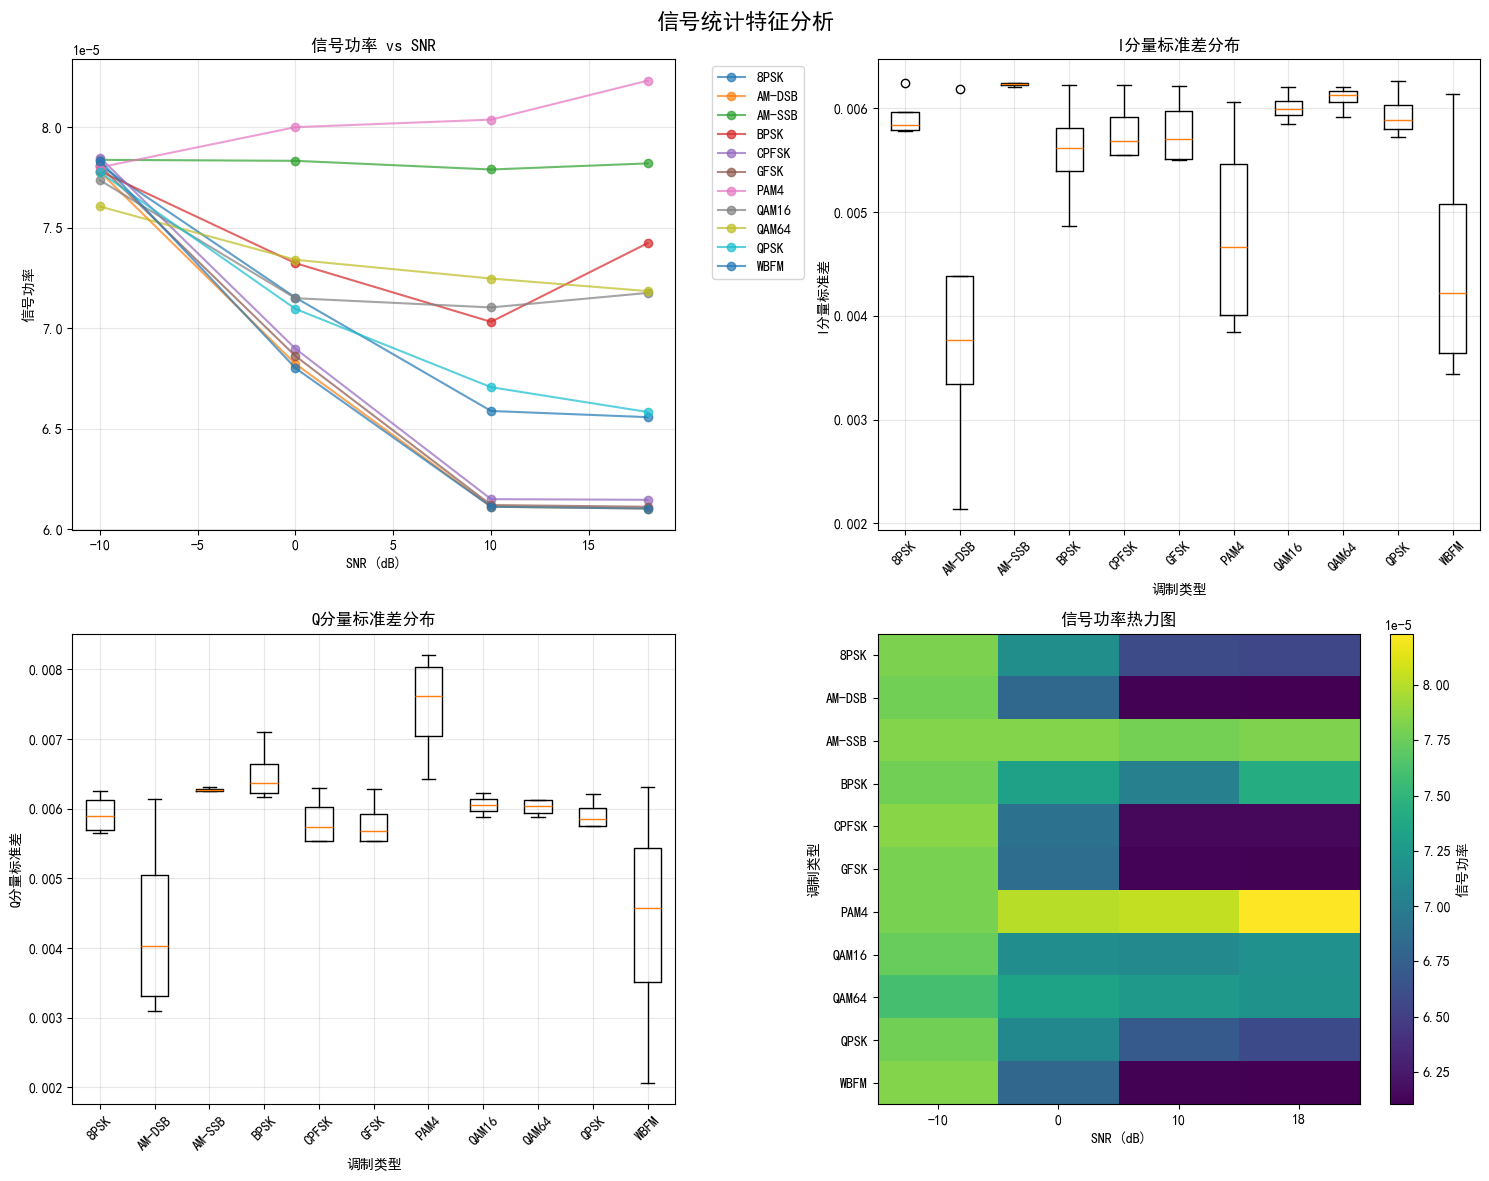

In [9]:
# 统计特征可视化
if dataset is not None and len(stats_data) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('信号统计特征分析', fontsize=16, fontweight='bold')
    
    # 1. 信号功率 vs SNR
    for mod in mods:
        mod_data = df_stats[df_stats['Modulation'] == mod]
        axes[0, 0].plot(mod_data['SNR'], mod_data['Signal_power'], 'o-', label=mod, alpha=0.7)
    
    axes[0, 0].set_title('信号功率 vs SNR')
    axes[0, 0].set_xlabel('SNR (dB)')
    axes[0, 0].set_ylabel('信号功率')
    axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. I分量标准差分布
    axes[0, 1].boxplot([df_stats[df_stats['Modulation'] == mod]['I_std'].values for mod in mods], 
                       labels=mods)
    axes[0, 1].set_title('I分量标准差分布')
    axes[0, 1].set_xlabel('调制类型')
    axes[0, 1].set_ylabel('I分量标准差')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Q分量标准差分布  
    axes[1, 0].boxplot([df_stats[df_stats['Modulation'] == mod]['Q_std'].values for mod in mods],
                       labels=mods)
    axes[1, 0].set_title('Q分量标准差分布')
    axes[1, 0].set_xlabel('调制类型')
    axes[1, 0].set_ylabel('Q分量标准差')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. 信号功率热力图
    power_pivot = df_stats.pivot(index='Modulation', columns='SNR', values='Signal_power')
    im = axes[1, 1].imshow(power_pivot.values, cmap='viridis', aspect='auto')
    axes[1, 1].set_xticks(range(len(analysis_snrs)))
    axes[1, 1].set_xticklabels([f'{snr}' for snr in analysis_snrs])
    axes[1, 1].set_yticks(range(len(mods)))
    axes[1, 1].set_yticklabels(mods)
    axes[1, 1].set_title('信号功率热力图')
    axes[1, 1].set_xlabel('SNR (dB)')
    axes[1, 1].set_ylabel('调制类型')
    plt.colorbar(im, ax=axes[1, 1], label='信号功率')
    
    plt.tight_layout()
    plt.show()


=== SNR对信号质量的影响分析 ===
分析调制类型: QAM16


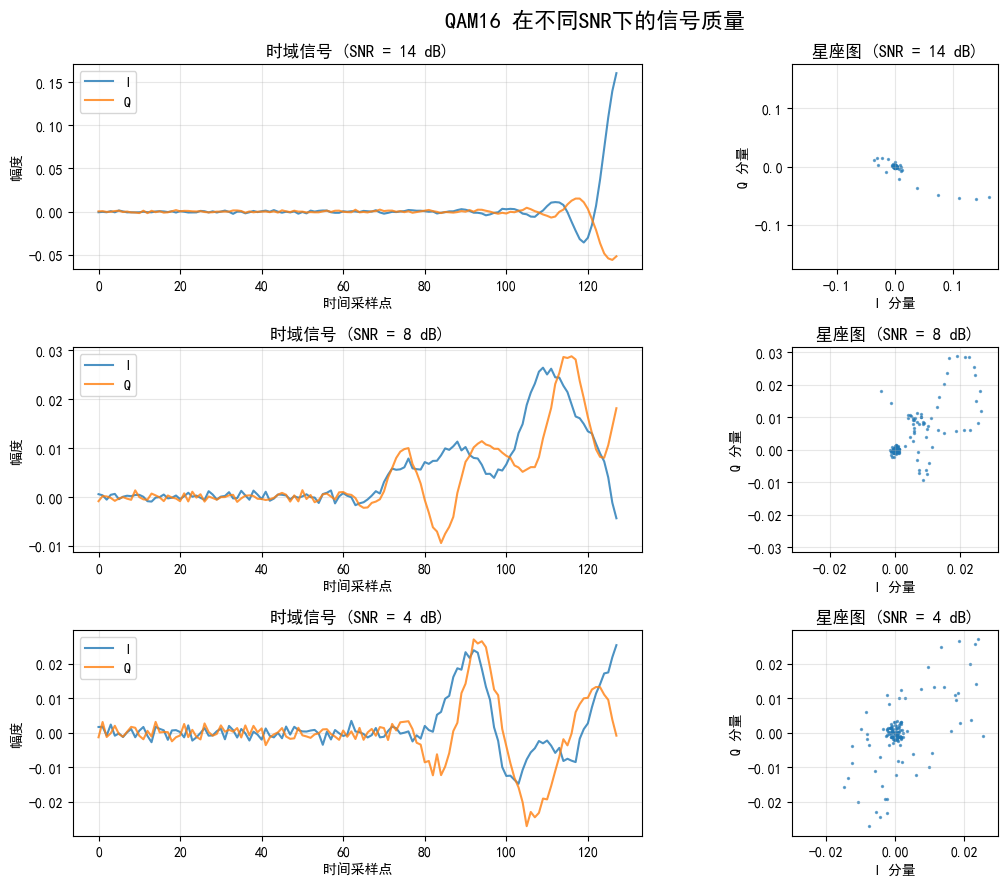

In [16]:
# SNR对信号质量的影响分析
if dataset is not None:
    print("\n=== SNR对信号质量的影响分析 ===")
    
    # 选择一个代表性的调制类型进行详细分析
    target_mod = 'QAM16'  # 四相移键控，比较典型
    print(f"分析调制类型: {target_mod}")
    
    # 选择几个关键SNR值
    # snr_levels = range(18, 0, -2)
    snr_levels = [14, 8, 4]

    fig, axes = plt.subplots(len(snr_levels), 2, figsize=(12, 3*len(snr_levels)))
    fig.suptitle(f'{target_mod} 在不同SNR下的信号质量', fontsize=16, fontweight='bold')
    
    for i, snr in enumerate(snr_levels):
        key = (target_mod, snr)
        if key in dataset:
            # 获取第一个样本
            sample = dataset[key][0]
            i_component = sample[0, :]
            q_component = sample[1, :]
            time_axis = np.arange(len(i_component))
            
            # 时域信号
            axes[i, 0].plot(time_axis, i_component, label='I', alpha=0.8)
            axes[i, 0].plot(time_axis, q_component, label='Q', alpha=0.8)
            axes[i, 0].set_title(f'时域信号 (SNR = {snr} dB)')
            axes[i, 0].set_xlabel('时间采样点')
            axes[i, 0].set_ylabel('幅度')
            axes[i, 0].legend()
            axes[i, 0].grid(True, alpha=0.3)
            
            # 星座图
            axes[i, 1].scatter(i_component, q_component, alpha=0.6, s=2)
            axes[i, 1].set_title(f'星座图 (SNR = {snr} dB)')
            axes[i, 1].set_xlabel('I 分量')
            axes[i, 1].set_ylabel('Q 分量')
            axes[i, 1].grid(True, alpha=0.3)
            axes[i, 1].set_aspect('equal')
            
            # 设置合理的坐标轴范围
            max_val = max(np.max(np.abs(i_component)), np.max(np.abs(q_component)))
            axes[i, 1].set_xlim([-max_val*1.1, max_val*1.1])
            axes[i, 1].set_ylim([-max_val*1.1, max_val*1.1])
    
    plt.tight_layout()
    plt.show()


=== 频域特征分析 ===
分析调制类型: BPSK, QPSK, 8PSK, QAM16, QAM64


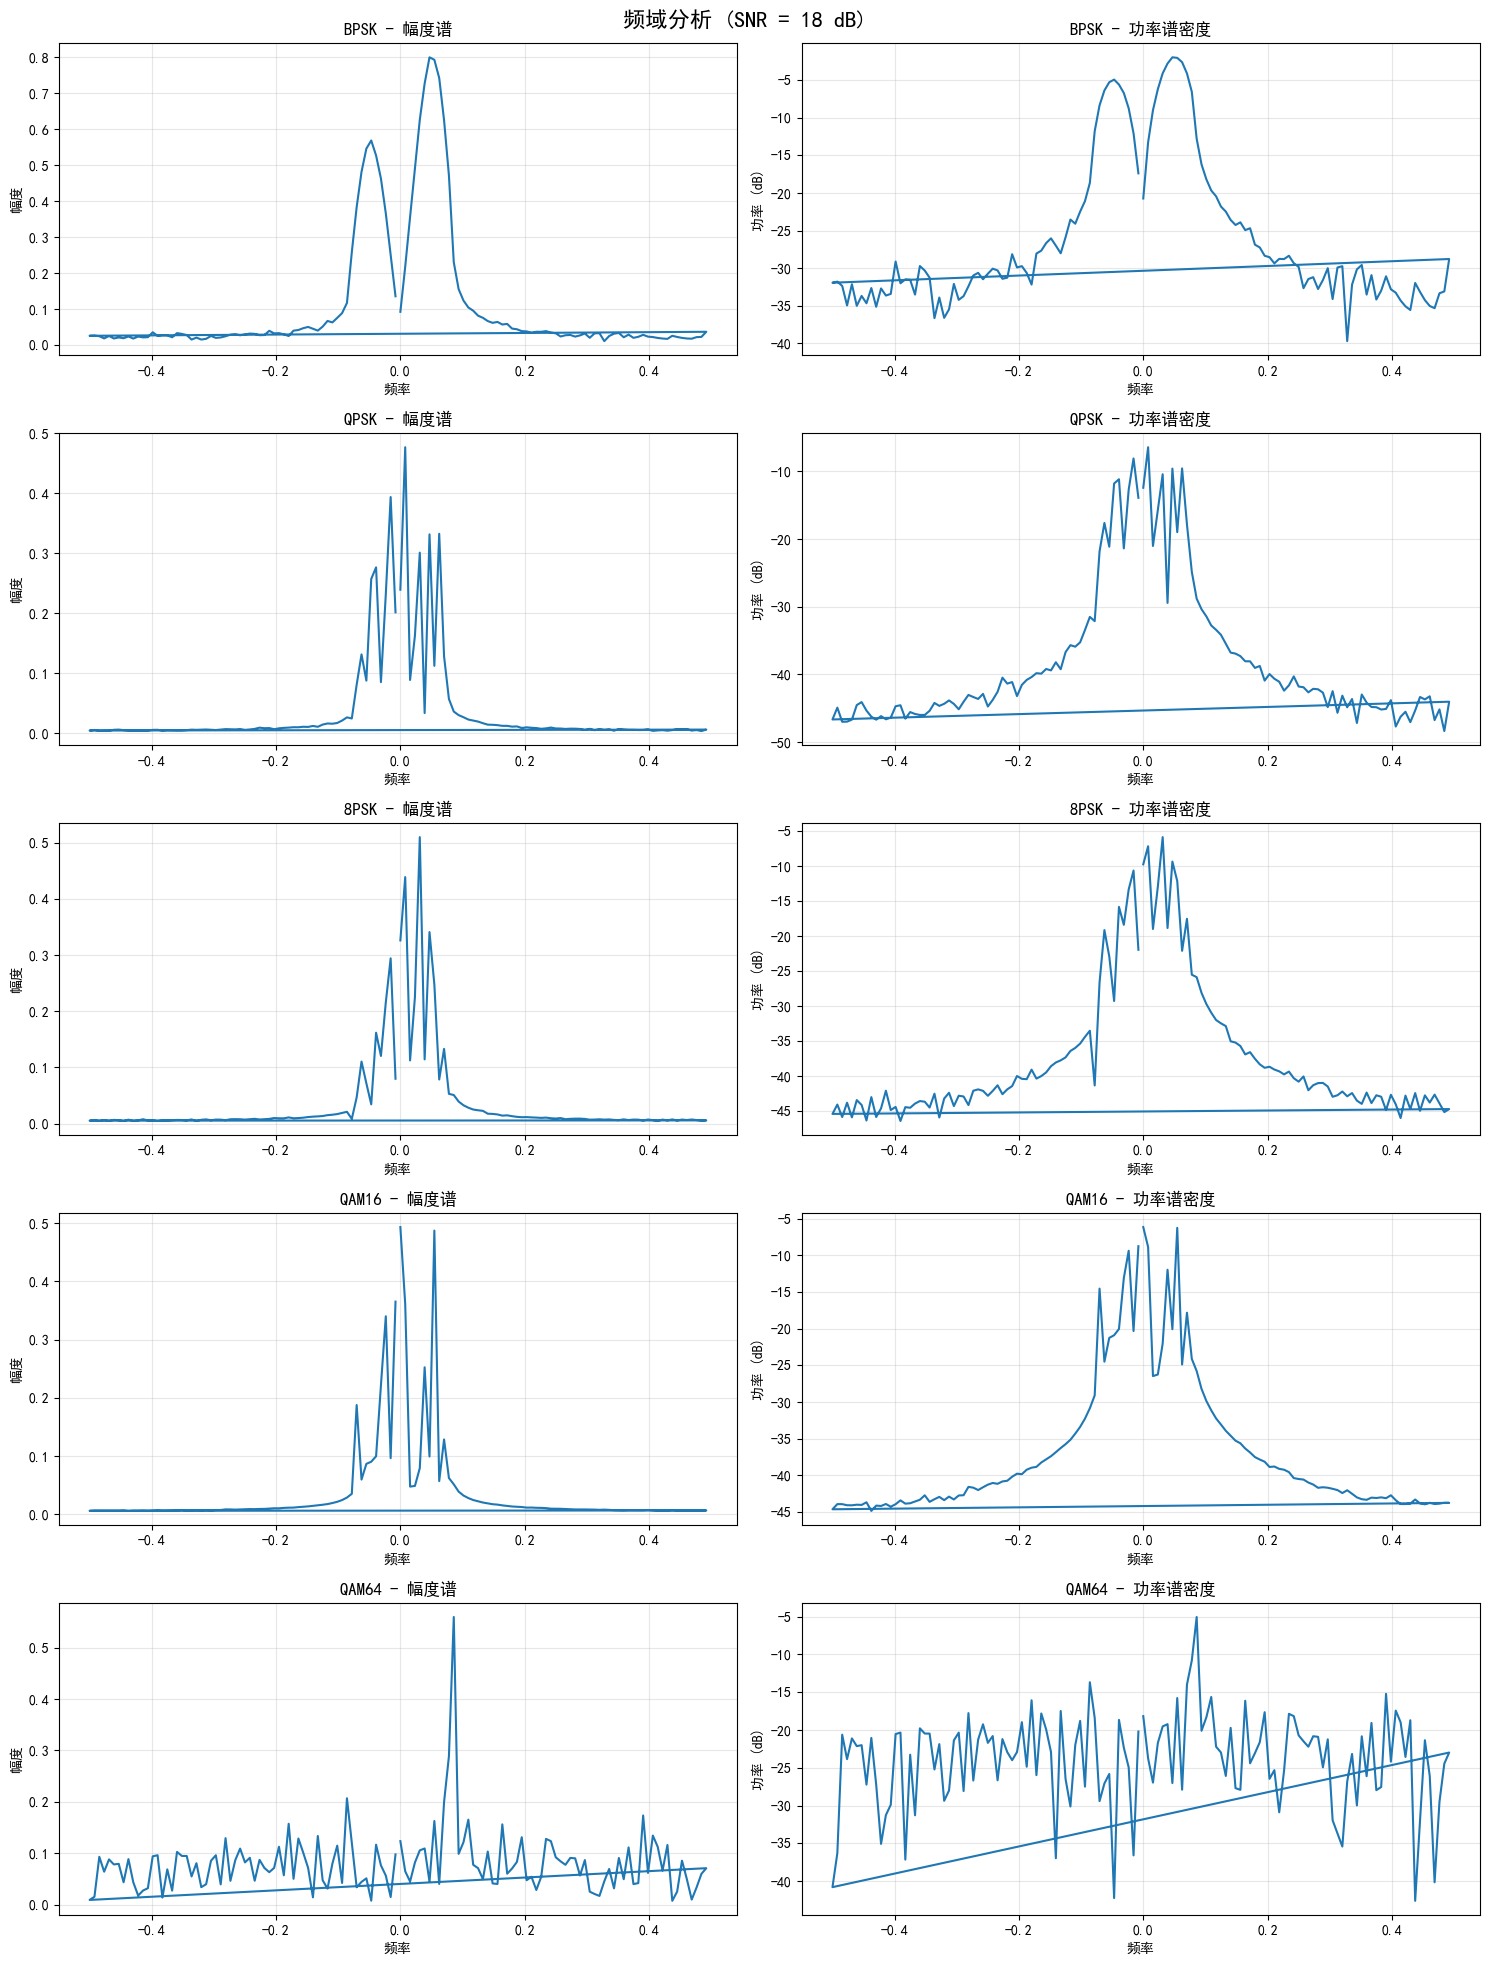

In [11]:
# 频域分析
def plot_frequency_analysis(dataset, modulations, snr_value=18, sample_rate=1.0):
    """绘制频域分析图"""
    fig, axes = plt.subplots(len(modulations), 2, figsize=(15, 4*len(modulations)))
    fig.suptitle(f'频域分析 (SNR = {snr_value} dB)', fontsize=16, fontweight='bold')
    
    for i, mod in enumerate(modulations):
        key = (mod, snr_value)
        if key in dataset:
            # 获取第一个样本
            sample = dataset[key][0]
            i_component = sample[0, :]
            q_component = sample[1, :]
            
            # 复信号
            complex_signal = i_component + 1j * q_component
            
            # FFT分析
            fft_result = np.fft.fft(complex_signal)
            freqs = np.fft.fftfreq(len(complex_signal), d=1/sample_rate)
            
            # 功率谱密度
            psd = np.abs(fft_result) ** 2
            
            # 幅度谱
            axes[i, 0].plot(freqs, np.abs(fft_result))
            axes[i, 0].set_title(f'{mod} - 幅度谱')
            axes[i, 0].set_xlabel('频率')
            axes[i, 0].set_ylabel('幅度')
            axes[i, 0].grid(True, alpha=0.3)
            
            # 功率谱密度
            axes[i, 1].plot(freqs, 10*np.log10(psd + 1e-12))  # 添加小值避免log(0)
            axes[i, 1].set_title(f'{mod} - 功率谱密度')
            axes[i, 1].set_xlabel('频率')
            axes[i, 1].set_ylabel('功率 (dB)')
            axes[i, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

if dataset is not None:
    print("\n=== 频域特征分析 ===")
    
    # 选择几个代表性的调制类型进行频域分析
    freq_analysis_mods = ['BPSK', 'QPSK', '8PSK', 'QAM16', 'QAM64']
    available_mods = [mod for mod in freq_analysis_mods if mod in mods]
    
    if available_mods:
        print(f"分析调制类型: {', '.join(available_mods)}")
        plot_frequency_analysis(dataset, available_mods, snr_value=18)
    else:
        print("没有找到指定的调制类型用于频域分析")

In [12]:
# 数据质量评估
if dataset is not None:
    print("\n=== 数据质量评估 ===")
    
    # 检查数据完整性
    missing_keys = []
    for mod in mods:
        for snr in snrs:
            key = (mod, snr)
            if key not in dataset:
                missing_keys.append(key)
    
    print(f"缺失的键值对数量: {len(missing_keys)}")
    if missing_keys:
        print("缺失的键值对:")
        for key in missing_keys[:10]:  # 只显示前10个
            print(f"  {key}")
        if len(missing_keys) > 10:
            print(f"  ... 还有 {len(missing_keys) - 10} 个")
    
    # 检查样本数量一致性
    sample_counts = {}
    for key in dataset.keys():
        count = len(dataset[key])
        if count not in sample_counts:
            sample_counts[count] = 0
        sample_counts[count] += 1
    
    print(f"\n样本数量分布:")
    for count, num_keys in sorted(sample_counts.items()):
        print(f"  {count} 个样本: {num_keys} 个键值对")
    
    # 检查数据范围
    print("\n数据范围检查:")
    all_i_values = []
    all_q_values = []
    
    # 随机抽样检查（避免内存问题）
    sample_keys = list(dataset.keys())[:50]  # 检查前50个键
    
    for key in sample_keys:
        samples = dataset[key][:10]  # 每个键检查前10个样本
        for sample in samples:
            all_i_values.extend(sample[0, :])
            all_q_values.extend(sample[1, :])
    
    print(f"I分量范围: [{np.min(all_i_values):.4f}, {np.max(all_i_values):.4f}]")
    print(f"Q分量范围: [{np.min(all_q_values):.4f}, {np.max(all_q_values):.4f}]")
    print(f"I分量均值: {np.mean(all_i_values):.4f} ± {np.std(all_i_values):.4f}")
    print(f"Q分量均值: {np.mean(all_q_values):.4f} ± {np.std(all_q_values):.4f}")
    
    # 数据质量评分
    completeness_score = 1.0 - len(missing_keys) / (len(mods) * len(snrs))
    consistency_score = 1.0 if len(sample_counts) == 1 else 0.8
    
    print(f"\n数据质量评分:")
    print(f"  完整性: {completeness_score:.2%}")
    print(f"  一致性: {consistency_score:.2%}")
    print(f"  总体评分: {(completeness_score + consistency_score) / 2:.2%}")


=== 数据质量评估 ===
缺失的键值对数量: 0

样本数量分布:
  1000 个样本: 220 个键值对

数据范围检查:
I分量范围: [-0.0263, 0.0310]
Q分量范围: [-0.0250, 0.0280]
I分量均值: -0.0000 ± 0.0054
Q分量均值: -0.0011 ± 0.0065

数据质量评分:
  完整性: 100.00%
  一致性: 100.00%
  总体评分: 100.00%



=== 11种调制类型星座图对比分析 ===

✓ 8PSK: 100个样本, 12800个数据点
✓ AM-DSB: 100个样本, 12800个数据点
✓ AM-SSB: 100个样本, 12800个数据点
✓ 8PSK: 100个样本, 12800个数据点
✓ AM-DSB: 100个样本, 12800个数据点
✓ AM-SSB: 100个样本, 12800个数据点
✓ BPSK: 100个样本, 12800个数据点
✓ CPFSK: 100个样本, 12800个数据点
✓ GFSK: 100个样本, 12800个数据点
✓ BPSK: 100个样本, 12800个数据点
✓ CPFSK: 100个样本, 12800个数据点
✓ GFSK: 100个样本, 12800个数据点
✓ PAM4: 100个样本, 12800个数据点
✓ QAM16: 100个样本, 12800个数据点
✓ QAM64: 100个样本, 12800个数据点
✓ PAM4: 100个样本, 12800个数据点
✓ QAM16: 100个样本, 12800个数据点
✓ QAM64: 100个样本, 12800个数据点
✓ QPSK: 100个样本, 12800个数据点
✓ WBFM: 100个样本, 12800个数据点
✓ QPSK: 100个样本, 12800个数据点
✓ WBFM: 100个样本, 12800个数据点


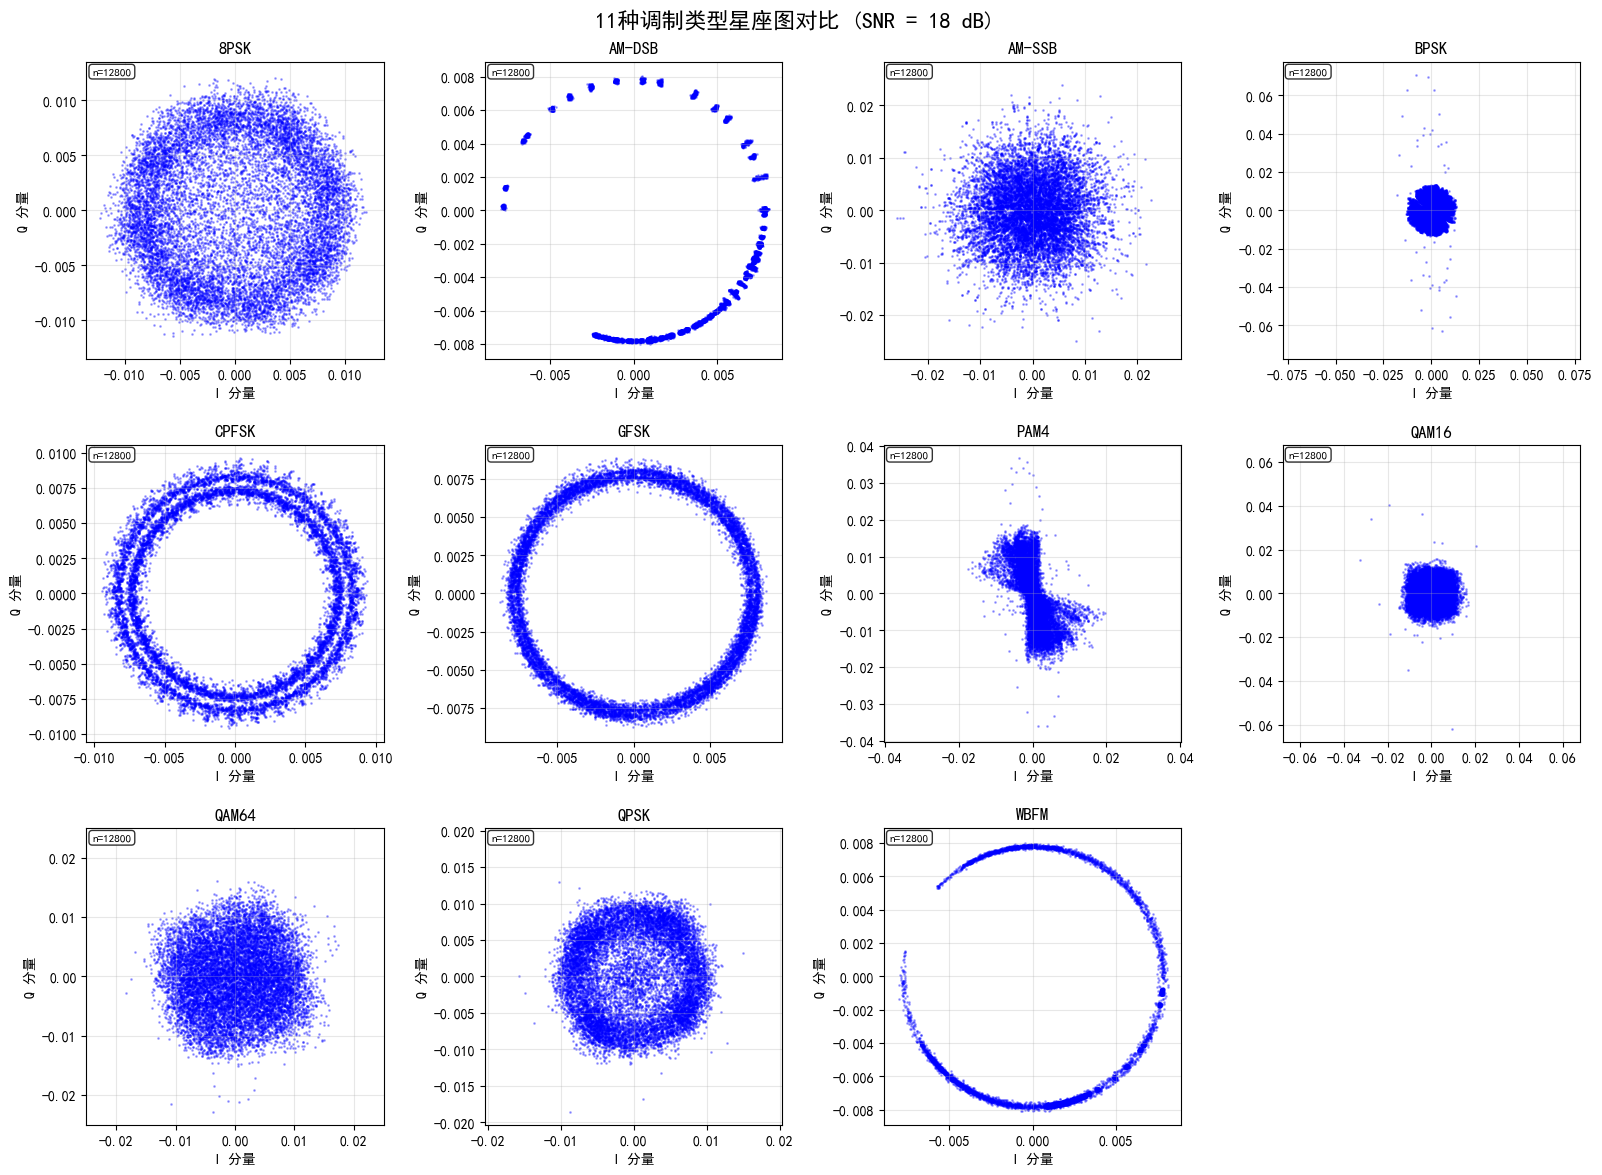


绘制完成！显示了11种调制类型在SNR=18dB下的星座图
每个调制类型使用100个样本，每个样本包含128个复数采样点


In [18]:
# 调制类型星座图对比分析
if dataset is not None:
    print("\n=== 11种调制类型星座图对比分析 ===\n")
    
    # 参数设置
    snr_value = 18  # 选择高SNR以获得清晰的星座图
    num_samples = 100  # 每个调制类型选取100条数据
    
    # 创建3x4的子图网格（11个调制类型 + 1个空位）
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    fig.suptitle(f'11种调制类型星座图对比 (SNR = {snr_value} dB)', 
                 fontsize=16, fontweight='bold')
    
    # 将axes展平为一维数组便于索引
    axes_flat = axes.flatten()
    
    for i, mod in enumerate(mods):
        if i < len(axes_flat):  # 确保不超出子图数量
            key = (mod, snr_value)
            
            if key in dataset:
                # 获取指定数量的样本
                samples = dataset[key][:num_samples]
                
                # 提取所有样本的I和Q分量
                all_i = []
                all_q = []
                
                for sample in samples:
                    i_component = sample[0, :]
                    q_component = sample[1, :]
                    all_i.extend(i_component)
                    all_q.extend(q_component)
                
                # 绘制星座图
                axes_flat[i].scatter(all_i, all_q, alpha=0.3, s=1, c='blue')
                axes_flat[i].set_title(f'{mod}', fontsize=12, fontweight='bold')
                axes_flat[i].set_xlabel('I 分量', fontsize=10)
                axes_flat[i].set_ylabel('Q 分量', fontsize=10)
                axes_flat[i].grid(True, alpha=0.3)
                axes_flat[i].set_aspect('equal')
                
                # 设置合理的坐标轴范围
                max_val = max(np.max(np.abs(all_i)), np.max(np.abs(all_q)))
                if max_val > 0:
                    axes_flat[i].set_xlim([-max_val*1.1, max_val*1.1])
                    axes_flat[i].set_ylim([-max_val*1.1, max_val*1.1])
                
                # 添加样本数量信息
                total_points = len(all_i)
                axes_flat[i].text(0.02, 0.98, f'n={total_points}', 
                                transform=axes_flat[i].transAxes, 
                                verticalalignment='top',
                                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                                fontsize=8)
                
                print(f"✓ {mod}: {len(samples)}个样本, {total_points}个数据点")
            else:
                # 如果没有该键，显示空白并标注
                axes_flat[i].text(0.5, 0.5, f'{mod}\n数据不可用', 
                                ha='center', va='center', transform=axes_flat[i].transAxes,
                                fontsize=10, color='red')
                axes_flat[i].set_title(f'{mod}', fontsize=12, fontweight='bold')
                print(f"✗ {mod}: 数据不可用")
    
    # 隐藏多余的子图
    for i in range(len(mods), len(axes_flat)):
        axes_flat[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n绘制完成！显示了{len(mods)}种调制类型在SNR={snr_value}dB下的星座图")
    print(f"每个调制类型使用{num_samples}个样本，每个样本包含128个复数采样点")

## 数据集分析总结

### 📊 数据集概况
- **调制类型**: 11种 (8PSK, AM-DSB, AM-SSB, BPSK, CPFSK, GFSK, PAM4, QAM16, QAM64, QPSK, WBFM)
- **SNR范围**: -20 dB 到 +18 dB，步长2 dB
- **总样本数**: 220,000个样本
- **信号长度**: 每个样本128个复数采样点
- **数据格式**: I/Q两路信号，形状为 (2, 128)

### 🔍 关键发现

1. **数据均衡性**: 所有调制类型和SNR级别的样本数量均匀分布，每个组合恰好1000个样本

2. **信号特征**:
   - 低SNR时信号被噪声严重污染，星座图模糊
   - 高SNR时星座图清晰，能明显区分不同调制类型的特征
   - 不同调制类型具有独特的时域和频域特征

3. **调制类型特点**:
   - **PSK系列** (BPSK, QPSK, 8PSK): 恒定包络，相位携带信息
   - **QAM系列** (QAM16, QAM64): 幅度和相位双重调制
   - **频率调制** (CPFSK, GFSK, WBFM): 频率变化携带信息
   - **幅度调制** (AM-DSB, AM-SSB, PAM4): 幅度变化明显

### 💡 模型训练建议

1. **数据预处理**:
   - 可考虑数据增强技术（旋转、加噪等）
   - 不同SNR级别可能需要不同的处理策略
   - 复数信号的幅度和相位信息都很重要

2. **特征工程**:
   - 时域特征：I/Q序列的统计特征
   - 频域特征：功率谱密度、频谱特征
   - 星座图特征：散点分布模式

3. **模型设计**:
   - 复数神经网络可能更适合处理I/Q信号
   - 卷积网络可以捕获时序模式
   - 注意力机制可以关注关键时间点

4. **训练策略**:
   - 可按SNR分层训练或采用课程学习
   - 交叉验证时注意保持SNR分布平衡
   - 考虑使用预训练模型进行迁移学习